In [1]:
# Marcin Damek, M.Cem Eriş, Mehmet Sezer, Recep O. Yıldız
# {damek20, erismu, sezer20, yildizr} @itu.edu.tr

# ITU BLG 549E Graph Theory and Algorithms Project

# Reference Metadata: 
# https://snap.stanford.edu/data/bigdata/amazon/amazon-meta.txt.gz

# TODO: Set the github to public
# TODO: Put comments about the much time spent for the parsing the metadata

# *****************************************************************************
# IMPORTANT NOTE:

# The Amazon Product Co-Purchasing Network Metadata Dataset in [1] has
# 548552 Products, 7781990 Reviews and 15010575 lines of data which is
# in total 977.5 MB.

# Due to its huge size, it takes nearly 40 minutes of parsing in a regular
# laptop. Therefore we decided to put parser code in a different Jupyter
# Notebook File named: amazon_metadata_parser.ipynb

# In order to save time to run this Jupyter Notebook file, the parsed data
# is stored in csv format. If there is a need to run the code from scratch
# please follow the steps below

# 1. Download the metadata [1] and save it in the same directory with the
#    Jupyter Notebook File named: amazon_metadata_parser.ipynb.
# 2. It creates all the matrices to run the analyzer and also images required
#    for the markdown cells of this file.
# 3. If the other products are desired for analysis, the product types 
#    should be changed.
# 4. After the successful execution of the amazon_metadata_parser.ipynb,
#    this Jupyter Notebook file is ready to be run.
# *****************************************************************************

import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import random

# 1. Graph Datasets
### (1) Present your graphs G1 and G2 (number of nodes, edges, what a node and edge denote).
#### Selected Graphs
SNAP (Stanford Network Analysis Project) Amazon Product Co-Purchasing Network Metadata Dataset is used in this project. This metadata can be accessed via reference [2]. <br>
Due to big size of products given below in numbers, Videos and DVDs are utilized. We have chosen "Videos" for Graph G1 and "DVDs" for Graph G2.

|Graphs      |Nodes |Edges|
|:-----------|:----:|----:|
|G1 (Videos) |26131 |16211|
|G2 (DVDs)   |19828 |39575|

The node degree distributions of both graphs are given below.

* The Node Degree Distribution of Graph G1
![degree_dist_G1](image_files/degree_dist_G1.png)

* The Node Degree Distribution of Graph G2
![degree_dist_G2](image_files/degree_dist_G2.png)

Since the number of nodes and edges are relatively high, it is decided to <b>remove the nodes with less than a designated node degree</b>. Therefore, the optimized graphs have the following features.

|Graphs      |Nodes |Edges|Threshold Node Degree|
|:-----------|:----:|:---:|:-------------------:|
|G1 (Videos) |453   |632  |13                   |
|G2 (DVDs)   |19828 |39575|16                   |

#### Node and Edge Representation
Each product in the metadata <b>creates a node</b> in the graphs. For the clear understanding of the edge representation, the metadata representation and its fields are given below.


|Field       |Explanation |
|:-----------|:-----------|
|Id          |Product Identification Number|
|ASIN        |Amazon Standard Identification Number [3]|
|Title       |Name/Title of The Product|
|Group       |Product Group (Book, DVD, Video or Music)|
|Salesrank   |Amazon Salesrank|
|Similar     |ASINs of Co-purchased Products (People who buy X also buy Y)|
|Categories  |Location in Product Category Hierarchy to Which the Product Belongs (Separated By Pipe Character, Category ID in [])|
|Reviews     |Product Review Information: Time, User ID, Rating, Total Number of Votes on the Review, Total Number of Helpfulness Votes (Note)|

* Note: How many people found the review to be helpful?

One of the products in the metadata is given as an example:

<b>Id</b>: 123499<br>
<b>ASIN</b>: 6304812663<br>
<b>title</b>: Spice Girls - Girl Power (Live in Istanbul)<br>
<b>group</b>: Video<br>
<b>salesrank</b>: 19875<br>
<b>similar</b>: 5  6305212139  6304683235  0767808673  B00000JQV6  6305112401<br>
<b>categories</b>: 7<br>

    |[139452]|VHS[404272]|Genres[404274]|Music Video & Concerts[133]|Other Music[511482]|British[169252]
    ...
<b>reviews</b>: total: 44  downloaded: 44  avg rating: 4.5<br>

    1998-3-25  customer:  ATVPDKIKX0DER  rating: 5  votes:   0  helpful:   0
    1998-4-11  customer:  ATVPDKIKX0DER  rating: 5  votes:   0  helpful:   0
    1998-4-23  customer:  ATVPDKIKX0DER  rating: 5  votes:   0  helpful:   0
    ...

For edge representation "similar" field is used as an edge between two products. If there is a video which has a similar ASIN number which refers to an other type of product, it is ignored. The weight of an edge is assigned to a positive number by <b><u>summing up the total votes given to both of the products</u></b>. An example for the edge weight calculation is given below.
 
![Edge General Image](image_files/image_edges_general.png)

### (2) Display the adjacency matrices of both graphs. 

* Video Graph (G1) Adjacency Matrix
![AdjMatrixG1Raw](image_files/AdjMatrixG1Raw.png)

* DVDs Graph (G2) Adjacency Matrix
![AdjMatrixG2Raw](image_files/AdjMatrixG2Raw.png)

#### Colorbar is utilised in order to increase the perception of the adjacency matrices.

* Video Graph (G1) Adjacency Matrix with Enhanced Colorbar
![AdjMatrixG1VMax1](image_files/AdjMatrixG1VMax1.png)

* DVDs Graph (G2) Adjacency Matrix with Enhanced Colorbar
![AdjMatrixG2VMax1](image_files/AdjMatrixG2VMax1.png)

* Zoomed Video Graph (G1) Adjacency Matrix with Enhanced Colorbar
![AdjMatrixG1VMax1Zoomed](image_files/AdjMatrixG1VMax1Zoomed.png)

* Zoomed DVDs Graph (G2) Adjacency Matrix with Enhanced Colorbar
![AdjMatrixG2VMax1Zoomed](image_files/AdjMatrixG2VMax1Zoomed.png)

### (3) Plot the node degree distributions of both graphs in an overlaid manner.

The node degree distributions of both graphs.

* The Node Degree Distribution of Graph G1
![degree_dist_G1_thresholded](image_files/degree_dist_G1_thresholded.png)

* The Node Degree Distribution of Graph G2
![degree_dist_G2_thresholded](image_files/degree_dist_G2_thresholded.png)

TODO: Degree distributions are requested in an overlaid manner. I assume both of the distributions will be in the same histogram with different colors.

# 2. Graph Theory Principle

### (1) Present the mathematical principle or concept to explore.

Two principle/concepts are utilised in this project.

#### PageRank Centrality

PageRank centrality is derived from eigenvector centrality in which the in-degree of a node is examined as well as the number of connection of a node and its neighbors [4]. PageRank Centrality is utilised in order to find the central products in the given graphs.

#### Girvan-Newman Algorithm
In order to calculate the modules in the graphs the Girvan-Newman Algorithm is utilised. With Girvan-Newman Algorithm, the graphs are decomposed into the modules with the highest modularity.

### (2) Include a figure illustrating how it works on small graphs.

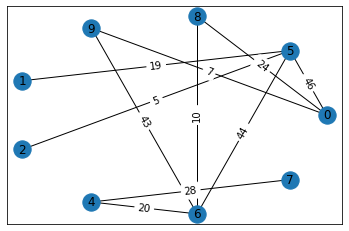

{0: 0.14414472204605722, 5: 0.21858044997749634, 8: 0.07236052898482756, 9: 0.09374831086318978, 1: 0.05136652144369119, 2: 0.029891774648924577, 4: 0.1091361499318012, 6: 0.207618764039765, 7: 0.07315277806424707}


In [28]:
def RandomAdjacencyMatrix(n, p):
    M = np.zeros((n,n), dtype=np.uint8)
    for i in range(n):
        for j in range(i+1, n):
            if np.random.rand() < p:
                M[i,j], M[j, i] = 1, 1
    return M

def RandomGraph(n, p, startw, stopw):
    '''
    Creates a random networkx undirected, unweighted graph
    
    Inputs:
        n: number of nodes in graph
        p: probability of an edge being included
        startw: start value for weight
        stopw: stop value of weight
        
    Outputs:
        M: Adjacency matrix as numpy array
        G: nx Graph
        
    '''
    M = RandomAdjacencyMatrix(n, p)
    edges = np.transpose(np.where(M==1))
    
    G = nx.Graph()
    for i in range(edges.shape[0]):
        G.add_edge(edges[i, 0], edges[i, 1], weight = random.randrange(startw, stopw))
    
    return G, M

def VisualizeGraph(G):
    pos = nx.circular_layout(G)
    nx.draw_networkx(G, pos)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.show()

def pagerank_centrality(G, alphaVal, max_iteration):
    return nx.pagerank(G, alpha = alphaVal, weight = "weight", max_iter = max_iteration)
    
n = 10
p = 0.2
strtw = 1
stopw = 50

max_iteration = 1000
alphaVal = 0.8 

G, M = RandomGraph(n, p, strtw, stopw)
VisualizeGraph(G)
print(pagerank_centrality(G, alphaVal, max_iteration))

### (3) Formalize the principle mathematically and present your mathematical symbols and equations with comments and explanations.

TODO: Girvan-Newman algorithm, and use the algorithm to decompose the network into a number of modules so that it has the highest modularity. Remember the steps of Girvan-Newman algorithm from Graph Theory Blink 9.3:

Calculate the betweenness centrality of each edge in graph G
Remove the edge with the highest betweenness centrality. Choose randomly in case same score occurs.
Recalculate the betweenness centrality of all remaining edges
Repeat steps 2 and 3 until no edges remain.

# 3. The R Space

### (1) Define R between two graph-driven metrics or properties P1 and P2 to better investigate the graph theory principle/concept you selected in Section 2. Justify your rationale for exploring such relationship.

TODO: P1 and P2 results can be get from the temp file.
TODO: Morphospace results will come here.

### (2) Simulate n1 = 100 random graphs derived from G1 with same node strength distribution.

### (3) Simulate n2 = 100 random graphs derived from G2 with same node strength distribution. Detail the simulation strategy.

Maslov-Sneppen firstly required ready network. The next step is to execute the randomization. We choose randomly two edges. Then we replace the end nodes in such a way that their in-degree, out-degree is not changed. This means that we act as follows. We select the A-B and C-D edges and then change them to A-> D and C-> B. Weights are copied too. If such a connection already existed, we interrupt the swap and look for another random pair.

### (4) For each anchor graph Gi, plot its node strength distribution overlaid with that of the simulated graphs from Gi. 

### (5) Plot the anchor graphs in the R space (as star) and the simulated graph populations in dots. For a better visualization, use two different colors.

# 4. Result Interpretation and Discussion

### Discuss and interpret the simulated graph behavior in the R space. Compare both simulated datasets and anchor graphs and derive conclusions.

## References

[1] “Amazon Product Metadata and Reviews from Summer 2006.” [Online]. Available: https://snap.stanford.edu/data/bigdata/amazon/amazon-meta.txt.gz. [Accessed: 31-Jan-2021].<br>
[2] “Amazon Product Co-purchasing Network Metadata.” [Online]. Available: https://snap.stanford.edu/data/amazon-meta.html. [Accessed: 31-Jan-2021].<br>
[3] “What are UPCs, EANs, ISBNs. and ASINs?” [Online]. Available: https://www.amazon.com/gp/seller/asin-upc-isbn-info.html. [Accessed: 31-Jan-2021].<br>
[4] Page, Lawrence and Brin, Sergey and Motwani, Rajeev and Winograd, Terry (1999) The PageRank Citation Ranking: Bringing Order to the Web. Technical Report. Stanford InfoLab.<br>
[5] Girvan M. and Newman M. E. J., Community structure in social and biological networks, Proc. Natl. Acad. Sci. USA 99, 7821–7826 (2002).<br>
[6] Ghalmane, Z., El Hassouni, M., Cherifi, C. et al. Centrality in modular networks. EPJ Data Sci. 8, 15 (2019). https://doi.org/10.1140/epjds/s13688-019-0195-7